# Chapter 6: Deep Convolutional GAN



The images we generated in Chapter 5 are relatively simple in shape. Therefore, we used only dense layers in the discriminator and the generator. To generate more realistic and high resolution images, we'll need more sophisticated neural networks. 

Convolutional Neural Networks (CNNs) use a different type of layers than fully-connected dense layers. A convolutional layer treats an image as a multi-dimensional object and finds patterns on the image. It then associates these patterns with different image labels and this, in turn, significantly improves the predictive accuracy of the neural network. In this chapter, you’ll learn to generate color images with higher resolutions by using deep convolutional GAN.  

Specifically, we'll show the model many examples of color images of Anime faces. The DCGAN model is able to learn the distribution of the sample images. After training, the generator will produce Anime faces that look fairly realistic. 

Start a new cell in ch06.ipynb and execute the following lines of code in it:

In [1]:
import os

os.makedirs("files/ch06", exist_ok=True)

# 1.  Download Anime Faces
Our goal is to train a model to generate color images of anime faces. We first download the training data and discuss how PyTorch handles color pictures. We then put the data in batches for training later. 

## 2.1. Anime Face Images
You can download the training data from Brian Chao's GitHub repository https://github.com/bchao1/Anime-Face-Dataset, which contains 63,632 color images of anime faces. Extract the data from the zip file and put the images on your computer. For example, I placed the images in C:\temp\anime on my computer. Define the path name so you can use it later to load the images to Pytorch:

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

anime_path = r"C:\temp\anime"

Change the name of the path depending on where you have saved the images on your computer. 

Next, we use the *ImageFolder* class in Torchvision *datasets* package to load up the dataset, like so:

In [3]:
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

transform = T.Compose([T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_data = ImageFolder(root=anime_path,
                         transform=transform)

We perform three different transformations when loading up the images from the local folder. First, we resized all images to 64 pixels in height and 64 pixels in width, by using the *Resize()* method. Second, we convert the images to PyTorch tensors in the range of 0 and 1 by using the *ToTensor()* method. Finally, we use the *Normalize()* method to deduct 0.5 from the value and divide the difference by 0.5. As a result, the image data are now between -1 and 1. 

Next, we create batches of the training data for the next section:

In [4]:
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(dataset=train_data, 
               batch_size=batch_size, shuffle=True)

The DataLoader class in the PyTorch *utils* package helps create data iterators in batches. We set the batch size to 128. 

## 2.2. Channels First Color Images

PyTorch uses channels first when handling color images. This means the shape of the images in PyTorch are (number_channels, height, width) instead of in other Python libraries such as TensorFlow or matplotlib that use the channels last system. Let's look at an example and print out out the shape:

In [5]:
image0, _ = train_data[0]
print(image0.shape)

torch.Size([3, 64, 64])


The shape of the first image is 3 by 64 by 64. This means the image has three color channels (RGB: red, green, and blue). The height and width of image are both 64 pixels. 

When we plot the images in *matplotlib*, we need to convert it to channels last by using the *permute()* method in PyTorch, like so: 

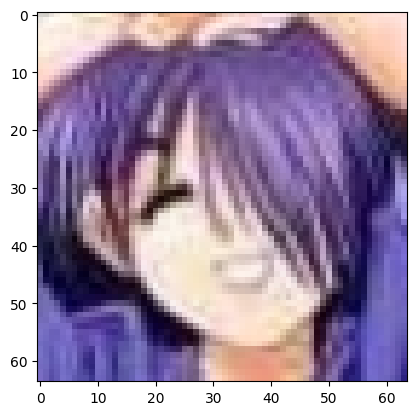

In [6]:
import matplotlib.pyplot as plt

plt.imshow(image0.permute(1,2,0)*0.5+0.5)
plt.show()

Note that we need to multiple the PyTorch tensor by 0.5 and then add 0.5 to convert the values from the range [-1, 1] to the range [0, 1]. 

Below, we define a function *plot_images()* to visualize 32 images in four rows and eight columns:

In [7]:
def plot_images(imgs):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(imgs[i].permute(1,2,0)/2+0.5)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()    

To test the function, we'll plot 32 images in the first batch, as follows

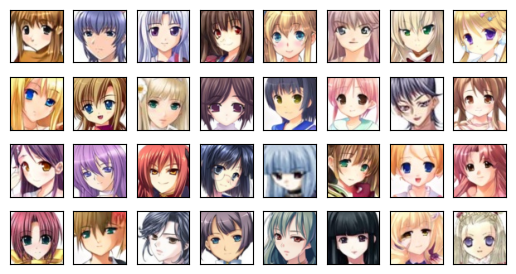

In [8]:
imgs, _ = next(iter(train_loader))
plot_images(imgs)

# 2. Create A Model
In this section, we create a deep convolutional GAN model so that we can train the model later to generate anime face images. 

## 2.1. A Discriminator in DCGAN
As usual, the discriminator D is a binary classifier to classify the samples into real or fake. However, different from the model we used in Chapter 5, we'll use convolutional layers in discriminator D. The structure of the discriminator neural network is as follows:

In [9]:
import torch.nn as nn
import torch

# determine the device automatically
device = "cuda" if torch.cuda.is_available() else "cpu"
D = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, 4, 2, 1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, 4, 1, 0, bias=False),
    nn.Sigmoid(),
    nn.Flatten()).to(device)

The input to the discriminator model is a color image with a shape of 3 by 64 by 64. The Conv2d layer takes a 2-dimensinal image and applies filters on it to extract the spatial features. It takes the following required arguments:
* in_channels: number of channels in the input image

* out_channels: number of channels after the convolutional layer

* kernel_size: the size of the kernel

The Conv2d layer also has several optional arguments, here are a few of them: 

* stride: the stride of the convolution with a default value of 1

* padding: padding added to four sides of the input image, with a default value of 0

* bias: whether or not to add a learnable bias as the parameter, with the default value True.

The BatchNorm2d layer normalizes the data at each dimension, and the LeakyReLU activation function allows the output to have a slope for values below zero. Specifically, the LeakyReLU function is defined as follows:

$$ReLU(x)\
=x\ if \ x>0 \\
ReLU(x)\
=x * negative\_slope \ if \ x\leq 0$$

## 2.2. The Generator G
The generator G's job is to create an image so that it can pass as real to the discriminator D. That is, G is trying to create an image to maximize the probability that D thinks the image is from the training dataset.

We create the following neural network to represent the generator G:

In [10]:
G=nn.Sequential(
    nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
    nn.Tanh()).to(device)

We'll feed random data from a 100-dimensional latent space, $(z_1, z_2, ..., z_{100})$, to the generator. The generator then generates a color image with values between -1 and 1 based on the input from the latent space. Note here we use the Tanh activation function at the output layer so the output are all in the range of -1 and 1, the same as the training images. The ConvTranspos2d layer performs the opposite operation of a Conv2d layer. This GitHub repository https://github.com/vdumoulin/conv_arithmetic/tree/master explains the difference between Conv2d and ConvTranspose2d layers. 

## 2.3. Optimizers and the Loss Function

As usual, the loss function is the binary cross-entropy loss. The discriminator D is trying to maximize the accuracy of the binary classification: identify a real sample as real and a fake sample as fake. The generator, on the other hand, is trying to minimize the probability that the fake sample is being identified as fake. 

We'll use the Adam optimizer for both the discriminator and the generator:

In [11]:
loss_fn=nn.BCELoss()
lr = 0.0002
optimG = torch.optim.Adam(G.parameters(), 
                         lr = lr, betas=(0.5, 0.999))
optimD = torch.optim.Adam(D.parameters(), 
                         lr = lr, betas=(0.5, 0.999))

# 3. Train the DCGAN
Now that we have the training data and two networks, we'll train the model. After that, we'll discard the discriminator and use the generator to generate color images of Anime faces. 

## 3.1. Test Ouput Periodically
We'll crate a function to test what the fake images generated by G look like. 

In [12]:
import matplotlib.pyplot as plt

def test():
    noise=torch.randn(batch_size,100,1,1).\
        to(device=device)
    fake_samples=G(noise).cpu().detach()
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake_samples.cpu().detach()[i]/2+0.5).\
            permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()    

Before training, the fake samples look as follows:

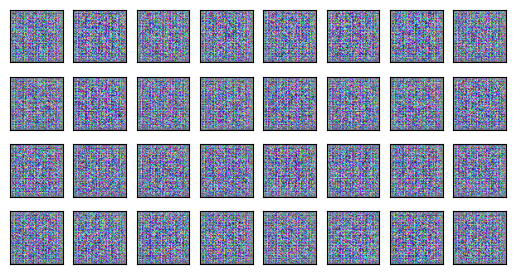

In [13]:
test()

As you can see, before training, the images produced by the generator look not at all like Anime faces. 

## 3.2. Train the Model
We first create labels of zeros and ones as follows:

In [14]:
real_labels=torch.ones((batch_size,1)).to(device)
fake_labels=torch.zeros((batch_size,1)).to(device)

The real labels are all ones, while the fake labels are all zeros. We'll compare these labels with the predictions from the discriminator to train both the discriminator and the generator. 

We train the model for 10 epochs, as follows:

at epoch 1, dloss: 0.23464426398277283, gloss 5.351285934448242


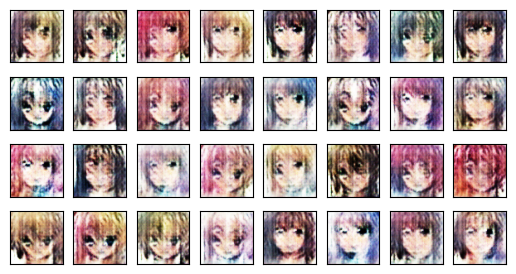

at epoch 2, dloss: 0.24496181309223175, gloss 8.250452041625977


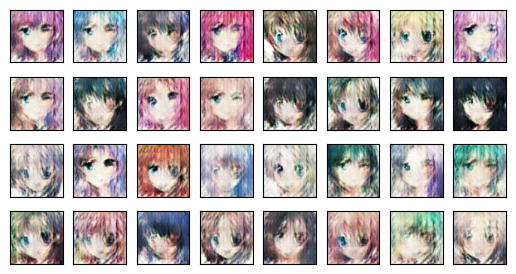

at epoch 3, dloss: 0.128709077835083, gloss 5.234643936157227


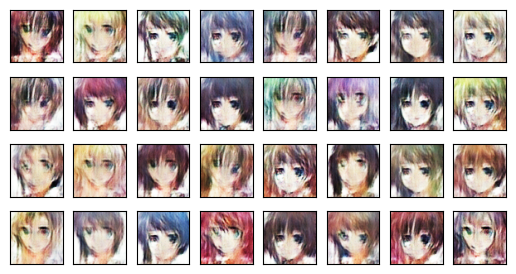

at epoch 4, dloss: 0.6510270833969116, gloss 19.42673110961914


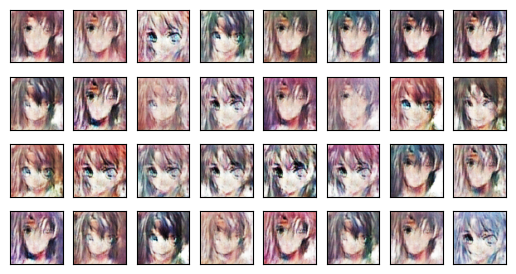

at epoch 5, dloss: 0.04974899813532829, gloss 9.64084243774414


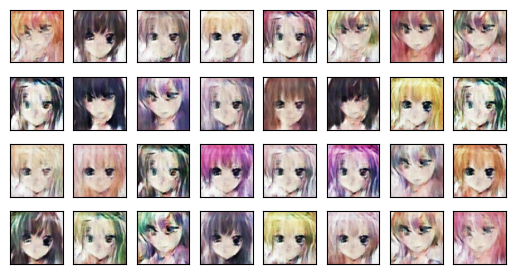

at epoch 6, dloss: 0.010277163237333298, gloss 13.832592010498047


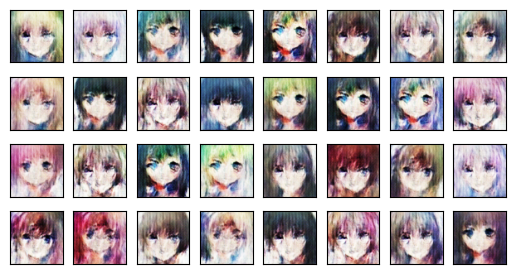

at epoch 7, dloss: 0.006391052156686783, gloss 7.109671592712402


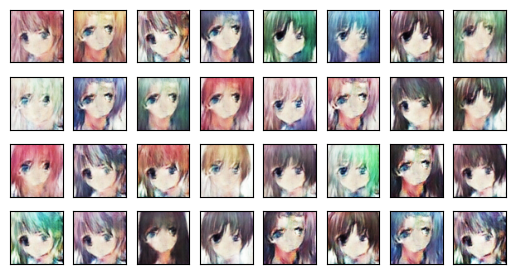

at epoch 8, dloss: 0.29432421922683716, gloss 19.790435791015625


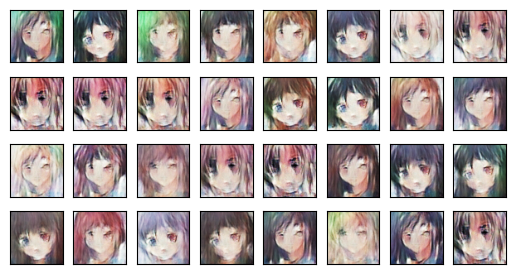

at epoch 9, dloss: 0.12558844685554504, gloss 10.505315780639648


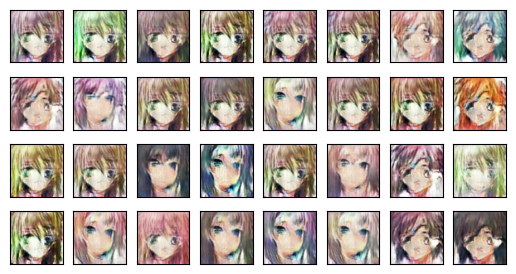

at epoch 10, dloss: 0.03175939619541168, gloss 7.0399699211120605


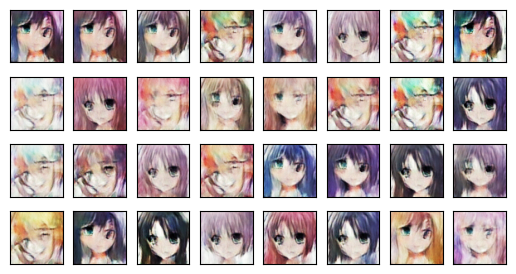

In [15]:
for i in range(10):
    for n, (real_samples,_) in enumerate(train_loader):    
        gloss=dloss=0
        # train discriminator on real data
        real_samples=real_samples.to(device)
        preds=D(real_samples)
        labels=torch.ones((real_samples.shape[0],1)).to(device)
        loss_D=loss_fn(preds,labels)
        optimD.zero_grad()
        loss_D.backward()
        optimD.step()
        dloss+=loss_D    
        # train D on fake data
        noise=torch.randn(batch_size,100,1,1).to(device)
        generated_data=G(noise)
        # use 0 as labels since they are fake
        preds=D(generated_data)
        loss_D=loss_fn(preds,fake_labels)
        optimD.zero_grad()
        loss_D.backward()
        optimD.step()
        dloss+=loss_D      
        # train G 
        noise=torch.randn(batch_size,100,1,1).to(device)
        generated_data=G(noise)
        # use 1 as labels since G wants to fool D
        preds=D(generated_data)
        loss_G=loss_fn(preds,real_labels)
        optimG.zero_grad()
        loss_G.backward()
        optimG.step()
        gloss+=loss_G      
    print(f"at epoch {i+1}, dloss: {dloss}, gloss {gloss}")
    test()

In each iteration, we first train the discriminator using the real samples. After that, the generator creates a batch of fake samples and we use them to train the discriminator D again. Finally, we let the generator create a batch of fake samples again, but we use them to train the generator instead.

After just one epoch of training, the model can already generate Anime faces that look real. 

## 3.3. Save and Use the Generator
We'll discard the discriminator and save the trained generator in the local folder, as follows:

In [16]:
# Export to TorchScript
scripted = torch.jit.script(G) 
# Save the model
import os
os.makedirs("files/ch06", exist_ok=True)
scripted.save('files/ch06/anime_gen.pt') 

We have now saved the generator to the local folder. To use the generator, we don't even need to define the model. We simply load up the model and use it to generate data points as follows: 

In [17]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
from torch import nn
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

new_G=torch.jit.load('files/ch06/anime_gen.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=G
  (net): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=ConvTranspose2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=ConvTranspose2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=ConvTranspose2d)
    (7): RecursiveScriptModule(original_name=BatchNorm2d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=ConvTranspose2d)
    (10): RecursiveScriptModule(original_name=BatchNorm2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=ConvTranspose2d)
    (13): RecursiveScriptModule(original_name=Tanh)
  )
)

The generator is now reloaded. We can use it to generate Anime faces as follows:

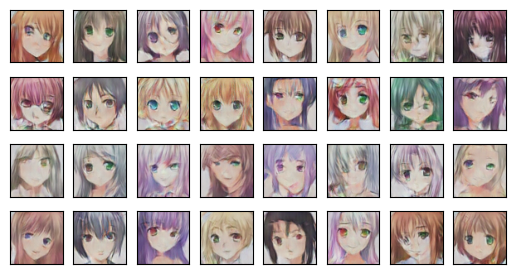

In [18]:
noise=torch.randn(batch_size,100,1,1).to(device)
fake_samples=new_G(noise).cpu().detach()
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(fake_samples.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=-0.6)
plt.show()  

The generated images are fairly close to the ones in the training set. 

# 4. Latent Space Encoding Arithmetic 
You may have noticed that the hair colors of the generated images are different: some are black, some are red, and some are blonde. You may wonder: can we tell the generator to create images with certain attributes, such as red hair? The answer is yes. We can achieve that by controlling the values in the latent space. 
## 4.1. Select Values in the Latent Space
First, we select the inputs *z* that produce images with red hair. By eyeballing the 32 images in section 3.3, we select images 4, 9, and 14 as follows (your numbers are likely to be different due to the random nature of the image generating process):

In [19]:
z1=noise[3,...]
z2=noise[8,...]
z3=noise[13,...]

We then average them as follows: 

In [20]:
z_red=(z1+z2+z3)/3

We can now generate an image based on the average value so the hair is red:

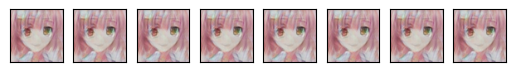

In [21]:
z_red=z_red.unsqueeze(0)
for i in range(8):
    ax = plt.subplot(1, 8, i + 1)
    fake=new_G(z_red).cpu().detach()
    img=(fake[0]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show() 

All the eight images have red hair. 

## 4.2. Encoding Arithmetic on Hair Color
We'll select another three images with black hair. We select images 2, 10, and 29 as follows::

In [22]:
z1=noise[1,...]
z2=noise[9,...]
z3=noise[28,...]

We then average them into as follows: 

In [23]:
z_black=(z1+z2+z3)/3
z_black=z_black.unsqueeze(0)

We can now use a weighted average of *z_red* and *z_black* to generate images that gradually transition from red to black hair:

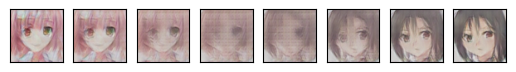

In [24]:
weights=[0,0.1428,0.2856,0.4284,0.5712,
        0.714,0.8568,1]
for i in range(8):
    ax = plt.subplot(1, 8, i + 1)
    # change the value of z
    z=weights[i]*z_black+(1-weights[i])*z_red
    fake=new_G(z).cpu().detach()
    img=(fake[0]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show() 

We put 0 weight on *z_black* and 100% weight on *z_red* in the first image. In the second image, we change the weights to 14.28% and 85.72%, respectively, and so on. As a result, you see the images gradually change from red hair to black hair. 

You can also try the same method on other hair colors such as purple or blonde, or other attributes such as eye color. But I'll leave that as an exercise for you. In Chapter 10, we'll revisit the encoding arithmetics in another generative model: variational autoencoders. 